In [1]:
source("../utils.R")
options(repr.plot.width = 10, repr.plot.height = 10)

Warning message in unit(c(t, r, b, l), unit):
“NAs introduced by coercion”


# Debug, profile, benchmark

<div class="subtitle1" id="coursename">
Techniques avancées en programmation statistique <strong>R</strong>
</div>
<div class="subtitle2" id="author">
Patrick Fournier<br>
Automne 2021<br>
Université du Québec À Montréal<br>
</div>

## Cours 1: Debug, profile, benchmark
1. Debug
2. Profile
3. Benchmark

## Debug

* Processus de recherche et de correction des bugs
* De ce point de vue, tout le monde a déjà débogué
* Plusieurs manières:
    + Méthode naïve: 
        * "À la main", avec `print` par exemple
        * Modification directe du code
    + Méthode interactive
        * Utilisation d'un débogueur

### Déboguage naïf

* Méthode très employée!
* Utile pour courtes fonctions / bugs simples

Workflow:
1. Ajouter des `print`au code
2. Exécuter le code augmenté
3. Modifier le code
4. Rincer et répéter

### Exemple (trouvez l'erreur)

In [2]:
fact <- function(x) {
    x < 0.0 && return(x)
    
    x * fact(x - 1.0)
}

fact(6)

[1] 0

### Déboguage interactif

* De base, **R** vient avec un débogueur respectable
* **R**Studio / VSCode enrichissent grandement l'expérience

Workflow:

1. Ajouter des breakpoints au code
2. Exécuter le code (interactivement)
3. Corriger le code

### Exemple

Vieux code!

In [12]:
## Retourne la probabilité théorique d'être malade.
y.th <- function(sexe, mutation){
    ## sexe: Sexe (0 = F, 1 = M).
    ## mutation: Possède la mutation (0 = Non, 1 = Oui).

    ## On s'assure que tous les arguments sont valides.
    if(mutation != 0)
        mutation <- 1
    if(sexe != 0)
        sexe <- 1

    ## Pr(Y = 1 | sexe, mutation)
    1 + 1 / (1 + 1.1 * 1.5^sexe * 2^mutation)
}

rmaladie <- function(n){
    ## n: Nombre de cas à générer.

    ##On s'assure de la validité de n.
    if(n < 1)
        n <- 1
    n <- floor(n)
    
    s <- runif(n) # Sexe (0 = F, 1 = M).
    m <- runif(n) # Possède la mutation (0 = Non, 1 = Oui).
    y <- runif(n) # Malade (0 = Non, 1 = Oui).

    ## On détermine le sexe de chaque individu, s'il est
    ## porteur de la mutation et s'il est malade.
    for(i in 1:n){
        ## Sexe
        if(s[i] < 0.5)
            s[i] <- 0
        else
            s[i] <- 1

        ## Mutation
        if(m[i] < 0.75)
            m[i] <- 0
        else
            m[i] <- 1

        ## Malade
        if(y[i] <  1 - y.th(s[i], m[i]))
            y[i] <- 0
        else
            y[i] <- 1
    }

    r <- as.data.frame(cbind(s, m, y))
    colnames(r) <- c("Sexe", "Mutation", "Malade")
    return(r)
}

rmaladie(10)

Sexe,Mutation,Malade
<dbl>,<dbl>,<dbl>
1,0,1
1,0,1
1,0,1
1,1,1
0,0,1
1,0,1
0,0,1
1,1,1
1,0,1


## Profile

* Analyse d'un logiciel visant à mesurer sa complexité
    + Spatiale
    + Temporelle
* Cours: complexité *spatiale*
* Autres quantités d'intérêt:
    + Utilisation d'une instruction précise
    + Fréquence des appels à des fonctions
    + ...
    
[Advanced **R**](https://adv-r.hadley.nz/perf-measure.html#profiling)

### Quand profiler?
* Possibilité de profiler $ \neq $ nécessité de profiler
* Devrait être la *première étape* de l'optimisation d'un logiciel
* Un logiciel ne devrait être optimisé que si nécessaire
    + "Premature optimization is the root of all evil"
* Optimisation
    + Prend du temps
    + Prompt à l'erreur
    + rend (souvent) le code plus difficile à comprendre

### Comment profiler?

* De base, R fournit `Rprof`
* RStudio rend l'expérience plus agréable

In [18]:
cutVector <- function(vec, m) {
  n <- length(vec) / m
  lapply(0:(m - 1),
          \(x) vec[seq(n * x + 1, n * (x + 1))])
}

dist0 <- function(m, n = 1e4){
  dat <- sample(0:9, size = n * m, replace = TRUE)
  dat_chopped <- cutVector(dat, m)
  
  sapply(dat_chopped, \(v) mean(v == 0))
}

dist0(4, 24)

[1] 0.16666667 0.12500000 0.04166667 0.16666667

## Benchmark

* Comparaison de différents logiciels/approches/méthodes/...
* Peut être faite en fonction de différents critères
    + Cours: complexité temporelle
* Vise à *choisir* un logiciel parmi un ensemble
    + Différent d'*améliorer* un logiciel (profilage)
* Exemple: étude de simulation

[Advanced **R**](https://adv-r.hadley.nz/perf-measure.html#microbenchmarking)

### Comment benchmarker?

* Méthode naïve: `system.time`
    + Très facile à mettre en place
    + Très peu d'overhead
    + Facile à interpréter

In [5]:
lmFast <- function(m){
    res <- numeric()

    for (kk in 1:m){
        random_values <- rnorm(1e6)
        X <- matrix(random_values, ncol = 20)
        X <- cbind(1, X)
        y <- rnorm(5e4)
        
        qrX <- qr(X)
        β <- qr.coef(qrX, y)
        res <- cbind(res, β)
    }
    rownames(res) <- c("(Intercept)", paste0("X", 1:20))
    res
}

In [6]:
lmSlow <- function(m){
    Xs <- rnorm(1e6 * m) |>       ## Génération des données.
        cutVector(m) |>           ## 1 entrée = 1 simulation.
        lapply(matrix, ncol = 20) ## vecteur -> matrice.

    ys <- cutVector(rnorm(5e4 * m), m)

    mapply(\(X, y) coef(lm(y ~ X)), Xs, ys)
}

In [7]:
system.time(lmSlow(20))

   user  system elapsed 
  3.823   0.215   2.589 

In [8]:
system.time(lmFast(20))

   user  system elapsed 
  3.351   0.069   1.805 

### Comment benchmarker?
<div class="caption1">
    Package Microbenchmark
</div>

* Facile à utiliser
    + Une seule fonction: `microbenchmark`
* Exécute un ensemble d'expressions un nombre fixé de fois
* Fourni des statistiques sommaires sur l'exécution
* Format `data.frame` $ \Rightarrow $ possibilité
    + Représentation graphique (`autoplot` ou tout simplement `boxplot`)
    + Analyses statistiques

In [9]:
library(microbenchmark)

mb <- microbenchmark(lmSlow(10), lmFast(10), times = 20)
print(mb)

Unit: milliseconds
       expr       min        lq      mean    median       uq       max neval
 lmSlow(10) 1092.8713 1169.8404 1198.9413 1196.4218 1226.319 1273.6825    20
 lmFast(10)  842.0691  861.6808  877.3882  880.8653  885.929  917.6642    20


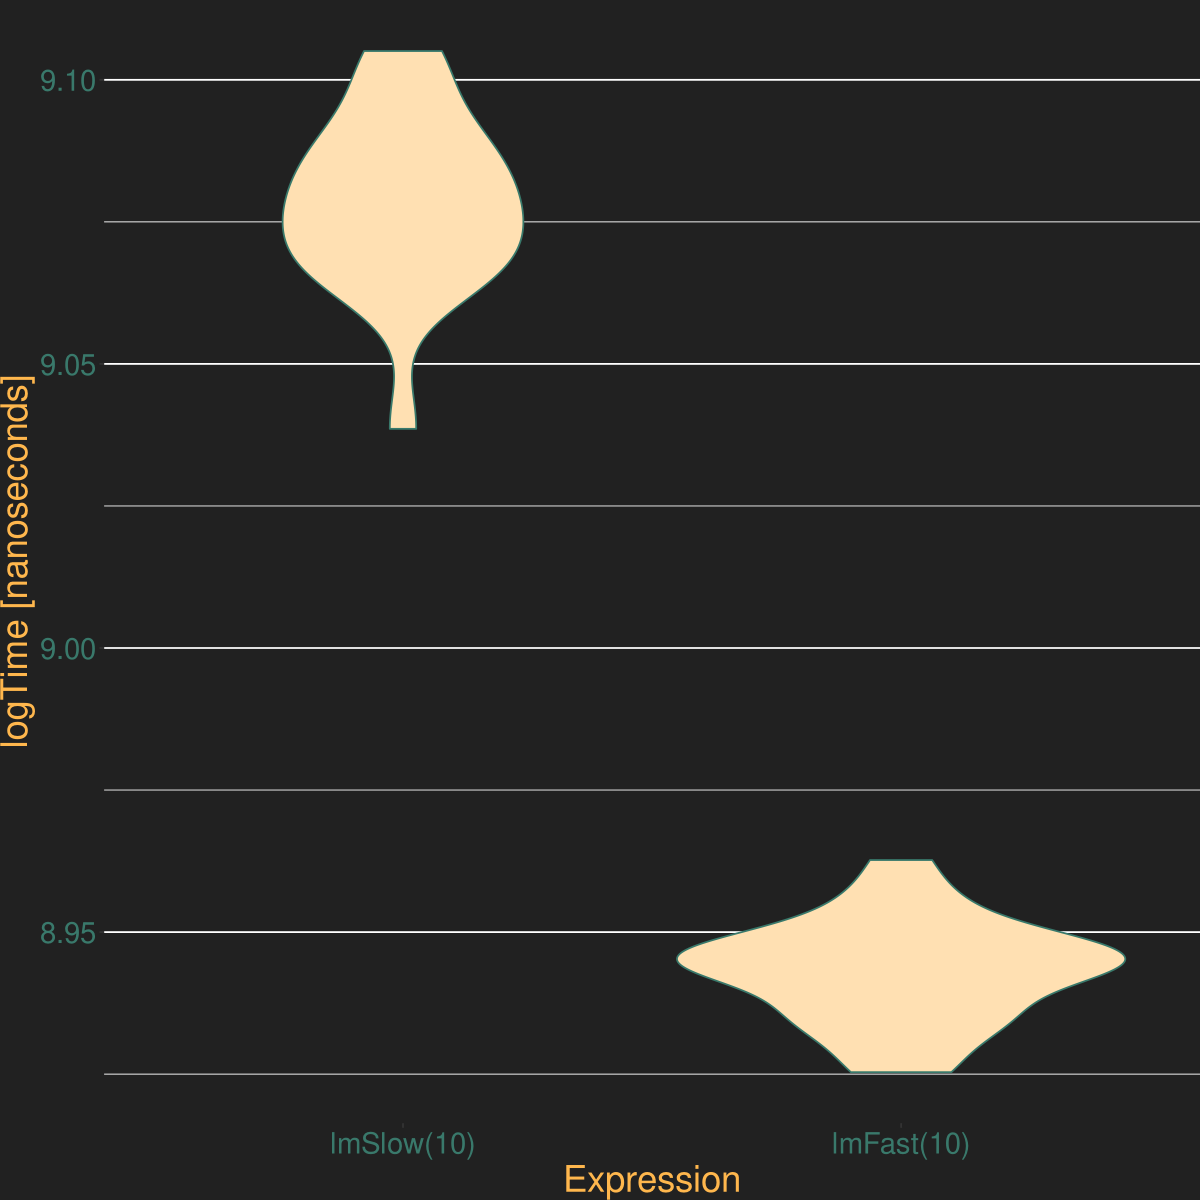

In [10]:
autoplot(mb)

### Comment benchmarker?
* Temps d'exécution $ \Rightarrow $ distribution asymétrique
* Moyenne 🤨
* Préférable d'utiliser la médiane ou le minimum

Retour sur l'exemple
* Mesure naïve: speedup de $ \approx 1.4$
* Microbenchmark (minimum): speedup de $ \approx 1.3$
* Microbenchmark (médiane): speedup de $ \approx 1.36$